In [1]:
# import modules
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import os

import random
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set()

In [4]:
# create Pandas dataframes and add the column "month"
files = [x for x in os.listdir('.') if x.endswith('csv')]
for file in files:
    df_i=pd.read_csv(file)
    df_i['month']=file[-7:-4]
    frame.append(df_i)
df=pd.concat(frame,ignore_index=True,sort=False)

# a quick examination of the dataframe
print("The dataframe has {} rows and {} columns.\n".format(df.shape[0],df.shape[1]))
print("Shown below are the first 3 rows of the dataframe:\n")
pd.set_option('display.max_columns', 100)
display(df.head(3))

/home/muha/anaconda3/envs/ml/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


The dataframe has 20789610 rows and 23 columns.

Shown below are the first 3 rows of the dataframe:



,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,month,Series_reference,Period,Data_value,STATUS,UNITS,MAGNTUDE,Subject,Group,Series_title_1,Series_title_2,Series_title_3,Series_title_4,Series_title_5
0,2020-01-01 00:00:00 UTC,view,5809910.0,1.602944e+18,NaN,grattol,5.24,595414620.0,4adb70bb-edbd-4981-b60f-a05bfd32683a,Jan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01 00:00:09 UTC,view,5812943.0,1.487580e+18,NaN,kinetics,3.97,595414640.0,c8c5205d-be43-4f1d-aa56-4828b8151c8a,Jan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01 00:00:19 UTC,view,5798924.0,1.783999e+18,NaN,zinger,3.97,595412617.0,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3,Jan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# data preparation

# step 1: select customers who purchased
df_sales=df.loc[df.event_type=='purchase',:]

# step 2: drop "category_code", "brand", "product_id", "category_id", and "user_session"
df_sales=df_sales.drop(columns=['category_code','brand','product_id','category_id','user_session'])

# step 3: drop duplicates
df_sales=df_sales.drop_duplicates()

# step 4: convert "event_time" to DateTime format
df_sales['event_time']=pd.to_datetime(df_sales['event_time'],infer_datetime_format=True)

nullcolumns=df_sales.isnull().sum()
nullnumbers=len(nullcolumns[nullcolumns!=0])
print("After data selection and cleansing, the dataframe has {} rows, {} columns, and {} null value.\n".format(df_sales.shape[0],df_sales.shape[1],nullnumbers))
print("Shown below are the first 3 rows of the cleaned dataframe:\n")
display(df_sales.head(3))

After data selection and cleansing, the dataframe has 908776 rows, 18 columns, and 13 null value.

Shown below are the first 3 rows of the cleaned dataframe:



,event_time,event_type,price,user_id,month,Series_reference,Period,Data_value,STATUS,UNITS,MAGNTUDE,Subject,Group,Series_title_1,Series_title_2,Series_title_3,Series_title_4,Series_title_5
60,2020-01-01 00:06:07+00:00,purchase,2.16,595411904.0,Jan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,2020-01-01 00:06:07+00:00,purchase,7.92,595411904.0,Jan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590,2020-01-01 00:51:38+00:00,purchase,14.51,595351517.0,Jan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


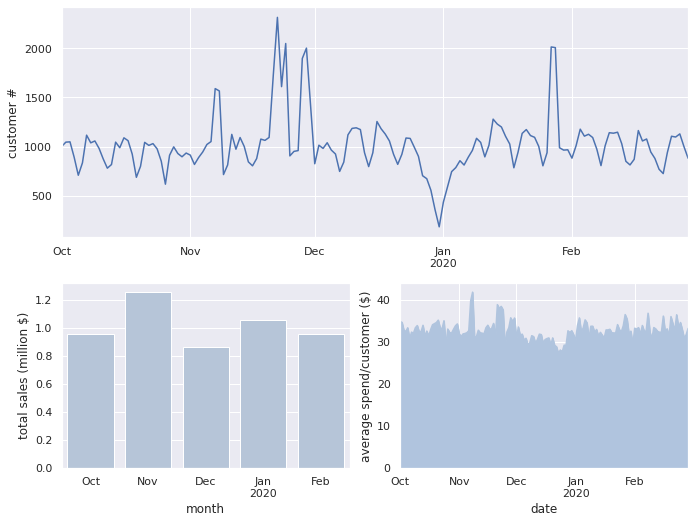

In [6]:
# initial data exploration

plt.figure(figsize=(10,8))

# plot the number of customers each day 
plt.axes([0.08, 0.4, 0.87, 0.4])
df_sales_n_user=df_sales.resample("D",on='event_time')['user_id'].nunique()
df_sales_n_user.plot(kind='line')
plt.xlabel('')
plt.ylabel('customer #')

# plot total sales/month 
plt.axes([0.08,0,0.4,0.32])
a=df_sales.resample('M',on='event_time')['price'].sum().to_frame()
a['month']=['Oct','Nov','Dec',"Jan\n2020", "Feb"]
a['price']=a['price']/1000000
sns.barplot(x='month',y='price',data=a,color="lightsteelblue")
plt.xlabel('month')
plt.ylabel('total sales (million $)')

# plot average spend/customer
plt.axes([0.55,0,0.4,0.32])
df_sales_p_day=df_sales.resample('D',on='event_time')['price'].sum()
df_sales_spent=df_sales_p_day/df_sales_n_user
df_sales_spent.plot(kind='area',color="lightsteelblue")
plt.xlabel('date')
plt.ylabel('average spend/customer ($)');

In [7]:
# group the data by "user_id", and calcualte each customer's recency, frequency, and monetary value

# step 1: calculate "Recency", set Feb 2020 as the reference month, and use "month" as the unit
d={"Oct":4,"Nov":3,"Dec":2,"Jan":1,"Feb":0}
df_sales.loc[:,'Recency']=df_sales['month'].map(d)
df_R=df_sales.groupby('user_id')['Recency'].min().reset_index().rename(columns={"0":"Recency"})

# step 2: calculate "Frequency"
df_F=df_sales.groupby('user_id')['event_type'].count().reset_index().rename(columns={"event_type":"Frequency"})

# step 3: calculate "Monetary"
df_M=df_sales.groupby('user_id')['price'].sum().reset_index().rename(columns={"price":"Monetary"})

# step 4: merge "Recency", "Frequency", and "Monetary"
df_RF=pd.merge(df_R,df_F,on='user_id')
df_RFM=pd.merge(df_RF,df_M,on='user_id')

# step 5: remove outliers before K-Means clustering
conditions=np.abs(stats.zscore(df_RFM.loc[:,['Recency','Frequency','Monetary']]) < 3).all(axis=1)
df_RFM2=df_RFM.loc[conditions,:]

df_RFM2.head(3)

,user_id,Recency,Frequency,Monetary
0,9794320.0,3,2,7.72
1,10079204.0,3,2,25.81
2,10280338.0,0,19,63.29


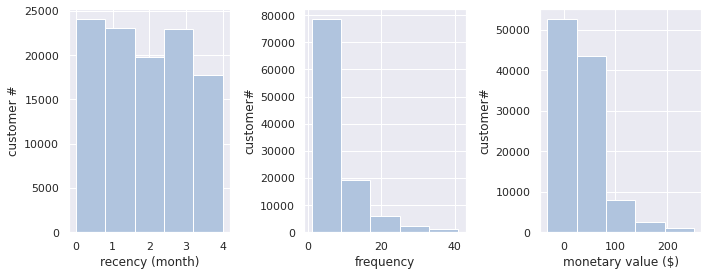

In [8]:
# visualize the distribution of "Recency", "Frequency", and "Monetary"
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,4))

# plot "Recency"
ax1.hist(df_RFM2['Recency'],bins=5,color='lightsteelblue')
ax1.set_xticks(np.arange(0,5,1))
ax1.set_xlabel('recency (month)')
ax1.set_ylabel('customer #')

# plot "Frequency"
ax2.hist(df_RFM2['Frequency'],bins=5,color='lightsteelblue')
ax2.set_xlabel('frequency')
ax2.set_ylabel('customer#')

# plot "Monetary"
ax3.hist(df_RFM2['Monetary'],bins=5,color='lightsteelblue')
ax3.set_xlabel('monetary value ($)')
ax3.set_ylabel('customer#')

plt.tight_layout()

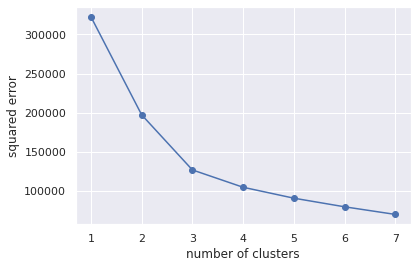

In [9]:
# k-means clustering: using recency, frequency, and monetary as clustering varaibles

# step 1: standardize data
df_RFM3=df_RFM2.drop(columns=['user_id'])
X = StandardScaler().fit_transform(df_RFM3)

# step 2: find the optimal number of clusters
SSE=[]
for i in range(1,8,1):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(X)
    SSE.append(kmeans.inertia_)
sns.set()
plt.plot(range(1,8,1),SSE,marker='o')
plt.xlabel('number of clusters')
plt.ylabel('squared error');

/tmp/ipykernel_26362/3023130614.py:26: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax=Axes3D(fig)


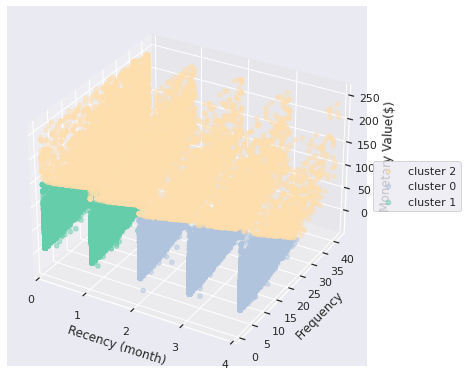

In [19]:
# k-means clustering: using recency, frequency, and monetary as clustering varaibles

# step 3: group customers into 4 clusters
random.seed(8)
km=KMeans(n_clusters=3,random_state=0)
km.fit(X)
random.seed(8)
pred=km.predict(X)
df_RFM2=df_RFM2.assign(clusters=pred)

# step 4: visualize the 4 clusters

# step 4_1: data preparation
R=[]
F=[]
M=[]
mycolors=['navajowhite','lightsteelblue','mediumaquamarine','thistle']
cluster_orders=[2,0,1]
for i in [0,1,2]:
    R.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Recency'].values.tolist())
    F.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Frequency'].values.tolist())
    M.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Monetary'].values.tolist())
    
# step 4_2: 3D scatter plot
fig=plt.figure(figsize=(8,5))
ax=Axes3D(fig)
for i in [0,1,2]:
    ax.scatter(R[i], F[i], M[i], c=mycolors[i], marker='o',alpha=0.5,label='cluster '+str(cluster_orders[i]))
ax.set_xlabel('Recency (month)')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value($)')
ax.set_xlim(0,3)
ax.set_xticks(list(range(5)))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

/tmp/ipykernel_26362/909001296.py:25: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax=Axes3D(fig)


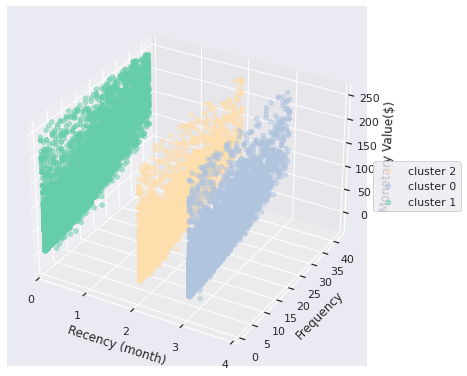

In [20]:
from sklearn.cluster import DBSCAN
# k-means clustering: using recency, frequency, and monetary as clustering varaibles

# step 3: group customers into 4 clusters
random.seed(8)
db=DBSCAN()
pred = db.fit_predict(X)
df_RFM2=df_RFM2.assign(clusters=pred)

# step 4: visualize the 4 clusters

# step 4_1: data preparation
R=[]
F=[]
M=[]
mycolors=['navajowhite','lightsteelblue','mediumaquamarine','thistle']
cluster_orders=[2,0,1]
for i in [0,1,2]:
    R.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Recency'].values.tolist())
    F.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Frequency'].values.tolist())
    M.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Monetary'].values.tolist())
    
# step 4_2: 3D scatter plot
fig=plt.figure(figsize=(8,5))
ax=Axes3D(fig)
for i in [0,1,2]:
    ax.scatter(R[i], F[i], M[i], c=mycolors[i], marker='o',alpha=0.5,label='cluster '+str(cluster_orders[i]))
ax.set_xlabel('Recency (month)')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value($)')
ax.set_xlim(0,3)
ax.set_xticks(list(range(5)))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

/tmp/ipykernel_26362/2771534065.py:27: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax=Axes3D(fig)


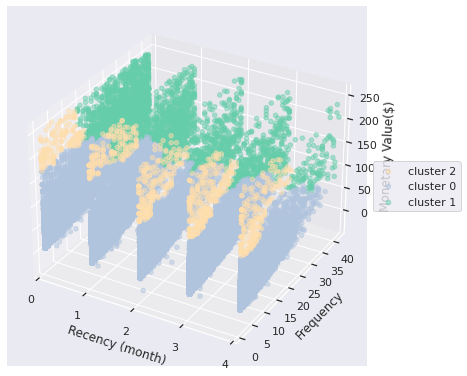

In [21]:
from sklearn.cluster import Birch
# k-means clustering: using recency, frequency, and monetary as clustering varaibles

# step 3: group customers into 4 clusters
random.seed(8)
bitch=Birch(n_clusters=3)
bitch.fit(X)
random.seed(8)
pred=bitch.predict(X)
df_RFM2=df_RFM2.assign(clusters=pred)

# step 4: visualize the 4 clusters

# step 4_1: data preparation
R=[]
F=[]
M=[]
mycolors=['navajowhite','lightsteelblue','mediumaquamarine','thistle']
cluster_orders=[2,0,1]
for i in [0,1,2]:
    R.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Recency'].values.tolist())
    F.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Frequency'].values.tolist())
    M.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Monetary'].values.tolist())
    
# step 4_2: 3D scatter plot
fig=plt.figure(figsize=(8,5))
ax=Axes3D(fig)
for i in [0,1,2]:
    ax.scatter(R[i], F[i], M[i], c=mycolors[i], marker='o',alpha=0.5,label='cluster '+str(cluster_orders[i]))
ax.set_xlabel('Recency (month)')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value($)')
ax.set_xlim(0,3)
ax.set_xticks(list(range(5)))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()